## NBA Shot Chart -- Game

Written by: Tim Chartier <br>
Adapted from: https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d


In [ ]:
!pip install nba_api

from nba_api.stats.endpoints import shotchartdetail

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 6.6 MB/s 
  Created wheel for nba-api: filename=nba_api-1.1.11-py3-none-any.whl size=251504 sha256=27ab550cf87b3249f8c80d1b24d32803de3f932b27df9c518643c31c23a79558
  Stored in directory: /root/.cache/pip/wheels/e3/f4/46/996128675381abc175e306642bae575d372dcf7efc4683e551
Successfully built nba-api


In [ ]:
# Import packages

import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Grab player ID number and team ID numbers

In [ ]:
# Load teams file
teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
# Load players file
players = json.loads(requests.get('https://lifeislinear.davidson.edu/sports/player_dicts.json').text)

### ID helper functions

Create helper functions that take an input of a team name and a player’s name, and return their respective ID numbers. In both cases, if a player or team name cannot be found, the functions return -1


In [ ]:
# Get team ID based on team name
def get_team_id(teamInput):
    for team in teams:
        if team['teamName'] == teamInput:
            return team['teamId']
    return -1
# Get player ID based on player name
def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return player['playerId']
    return -1
# Get Name based on player id
def get_player_name(playerId):
    for player in players:
        if player['playerId']==playerId:
            return player['firstName'], player['lastName']
    return -1

### See functions in action

In [ ]:
# Get the team ID number for the Knicks
teamID = get_team_id('Atlanta Hawks')
print(teamID)
# Get the player ID number for LeBron James
playerID = get_player_id('LeBron', 'James')
print(playerID)

1610612737
2544


### Collect shot data

documentation - https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md

For made shots change to: context_measure_simple = 'PTS',
   else FGA

To get regular season data, change:             
<dd>season_type_all_star = 'Regular Season')


In [ ]:
# Create JSON request
shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Golden State Warriors'),
            player_id = get_player_id('Stephen', 'Curry'),
            context_measure_simple = 'FGA',
            season_nullable = '2012-13',
            season_type_all_star = 'Regular Season')

# Load JSON data into dictionary
shot_data = json.loads(shot_json.get_json())

### What's a shot look like?

Each element/row represents a shot.  The second element in the list is the ID for hte game in which the shot was taken.

First, we will print the headers for the columns.  

In [ ]:
# Print column names.
print(shot_data['resultSets'][0]['headers'])
# Print one shot element
print(shot_data['resultSets'][0]['rowSet'][0])

['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']
['Shot Chart Detail', '0021200010', 33, 201939, 'Stephen Curry', 1610612744, 'Golden State Warriors', 1, 8, 31, 'Missed Shot', 'Jump Shot', '3PT Field Goal', 'Above the Break 3', 'Center(C)', '24+ ft.', 25, -45, 246, 1, 0, '20121031', 'PHX', 'GSW']


### Convert dictionary to a dataframe and extra shots from a game on a given date.

In [ ]:
shot_df = pd.concat(
    pd.DataFrame(shot, columns=shot_data['resultSets'][0]['headers'])
    for shot in [shot_data['resultSets'][0]['rowSet']]
)
#shot_df.head(10)

shot_df = shot_df[shot_df.GAME_DATE=='20130227']

print('There are %d shots by this player.\n' % len(shot_df))
shot_df.head()

There are 28 shots by this player.



,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
904,Shot Chart Detail,0021200853,9,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,9,...,Left Side Center(LC),24+ ft.,24,-183,164,1,0,20130227,NYK,GSW
905,Shot Chart Detail,0021200853,24,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,7,...,Center(C),8-16 ft.,11,-2,115,1,1,20130227,NYK,GSW
906,Shot Chart Detail,0021200853,30,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,5,...,Right Side(R),16-24 ft.,17,174,14,1,0,20130227,NYK,GSW
907,Shot Chart Detail,0021200853,89,201939,Stephen Curry,1610612744,Golden State Warriors,1,3,41,...,Center(C),Less Than 8 ft.,3,12,31,1,1,20130227,NYK,GSW
908,Shot Chart Detail,0021200853,95,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,34,...,Right Side(R),8-16 ft.,15,152,1,1,0,20130227,NYK,GSW


### You now have the API game ID.

In [ ]:
game_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Golden State Warriors'),
            player_id = get_player_id('Stephen', 'Curry'),
            context_measure_simple = 'FGA',
            game_id_nullable='0021200853')

game_data = json.loads(game_json.get_json())

# Make into a dataframe
game_df = pd.concat(
    pd.DataFrame(shot, columns=game_data['resultSets'][0]['headers'])
    for shot in [game_data['resultSets'][0]['rowSet']]
)
print(len(game_df))
game_df.head()

28


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021200853,9,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,9,...,Left Side Center(LC),24+ ft.,24,-183,164,1,0,20130227,NYK,GSW
1,Shot Chart Detail,0021200853,24,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,7,...,Center(C),8-16 ft.,11,-2,115,1,1,20130227,NYK,GSW
2,Shot Chart Detail,0021200853,30,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,5,...,Right Side(R),16-24 ft.,17,174,14,1,0,20130227,NYK,GSW
3,Shot Chart Detail,0021200853,89,201939,Stephen Curry,1610612744,Golden State Warriors,1,3,41,...,Center(C),Less Than 8 ft.,3,12,31,1,1,20130227,NYK,GSW
4,Shot Chart Detail,0021200853,95,201939,Stephen Curry,1610612744,Golden State Warriors,1,2,34,...,Right Side(R),8-16 ft.,15,152,1,1,0,20130227,NYK,GSW


### Pull the made and missed shots.

In relation to our shot chart in this program, we need to flip x coordinate about the x-axis.

In [ ]:
game_df.loc[:]['LOC_X'] = -game_df.loc[:]['LOC_X']

missedShots = game_df.loc[game_df['SHOT_MADE_FLAG'] == 0]
madeShots = game_df.loc[game_df['SHOT_MADE_FLAG'] == 1]

### Create function to draw the court

In [ ]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)

    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))

    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))

    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

### Create short chart

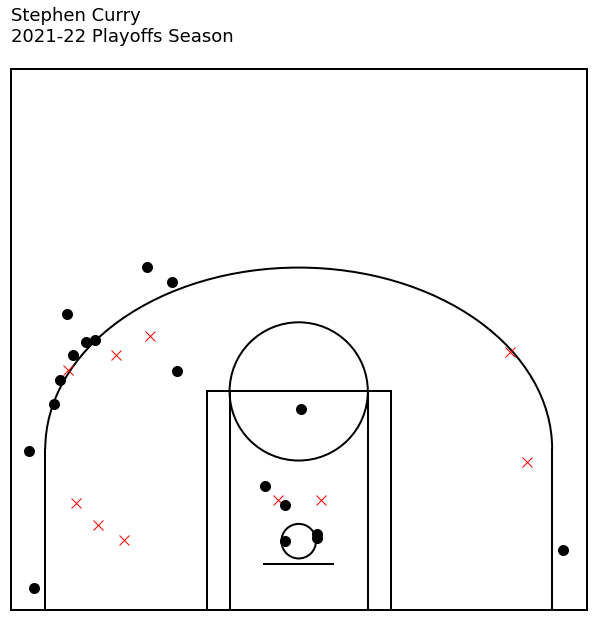

In [ ]:
# General plot parameters
#mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
#fig = plt.figure(figsize=(4, 3.76))
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

# Plot shotchart
plt.plot(missedShots['LOC_X'], missedShots['LOC_Y'] + 60,'rx',markersize=10)
plt.plot(madeShots['LOC_X'], madeShots['LOC_Y'] + 60,'ko',markersize=10)

ax = create_court(ax, 'black')
# Annotate player name and season
# fig.text(0, 1.05, 'Stephen Curry\n2021-22 Playoffs Season', ha='left', va='baseline')

#plt.savefig('curryShotchartPlayoffs.png',dpi=400,pad_inches=0,bbox_inches='tight')

plt.show()

### Save the data to a CSV file for use in spreadsheets

In [ ]:

#curry_data.to_csv('curryShots.csv')